In [1]:
# To create python file:
# jupyter nbconvert --to=python lang_model_new.ipynb

import utils.data_import as data_import
import utils.wiki_data as wiki_data
import utils.ml_utils as ml_utils
import model.neural as neural

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd
import numpy as np
import math
#from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm

import importlib

import settings

np.random.seed(123)

In [2]:
in_notebook = ml_utils.in_ipynb()
print('Running in notebook:', in_notebook)

Running in notebook: True


In [3]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')

if in_notebook:
    import matplotlib.pyplot as plt
    %matplotlib inline

No cuda.


In [4]:
corpus = wiki_data.WikiCorpus(file_path=settings.wikitext_path, lines=settings.lines)

Generated train: 62,570 tokens (1,000 lines)
Generated valid: 55,679 tokens (1,000 lines)
Generated test:  67,571 tokens (1,000 lines)
Generated vocab: 10,917
Generated oov:   4.0%


In [5]:
if settings.maxvocabsize < len(corpus.vocab):
    remove = corpus.vocab.least_frequent(len(corpus.vocab) - settings.maxvocabsize + 1)
    remove = [tok[0] for tok in remove]
    corpus.remove_token_list(remove)
    
corpus.vocab.export_vocab('vocab.p')

Exporting vocab to vocab.p... Done.


In [27]:
if in_notebook:
    print(corpus.vocab.most_frequent(to=20))

[('<upcase>', 20881), ('the', 10654), (',', 7963), ('<unk>', 7514), ('.', 6636), ('of', 4549), ('@', 4172), ('and', 3991), ('in', 3665), ('<eol>', 3004), ('to', 2942), ('a', 2600), ('was', 1634), ('"', 1608), ('-', 1473), ('on', 1087), ('as', 1084), ('for', 1046), (')', 1018), ('(', 1016)]


In [6]:
corpus.batchify(batch_size=settings.batch_size, seq_length=settings.window_size)

Batchifying train... Done.  torch.Size([1251, 50])
Batchifying valid... Done.  torch.Size([1113, 50])
Batchifying test...  Done.  torch.Size([1351, 50])


5094 24 28 7920 16 3 95 3 739 934 46 28 2248 83 18 2 14 1038 3246 1947 3 28 16 3 2186 16 3 7502 132 2751 14 39 2 7936 42 3095 3754 95 1646 6552 24 28 7971 16 2 46 563 42 18 2751 3 7502 95 3 739 1870 83 18 3 2703 2 14 2 132 1041 3 3885 3 198 17 None
especially as a receiver . <upcase> on <upcase> september 1 in a match against the <unk> , starting running back <upcase> a . <upcase> j . <upcase> harris was injured , and <unk> rushed for 73 yards on 12 carries as a backup . <unk> in again for the injured <upcase> harris on <upcase> september 13 against the <upcase> montreal <unk> , <unk> was named <upcase> canadian <upcase> player of None
tensor([6507,   23,    3,  551,    3, 6576,   14,  230,  221,    3, 5652, 2343,
         105,   24,   18, 6577, 6578,   14,    3, 4231,    2,   16,    3,  777,
        6579,   39, 4394,   14,  218, 2714, 6508, 6520,  628,   45,  117,    2,
          46,    2,   14,  162,   18, 2343,  961,  160,  350, 1061,  249,   16,
           1,    1,    3, 2560,    1

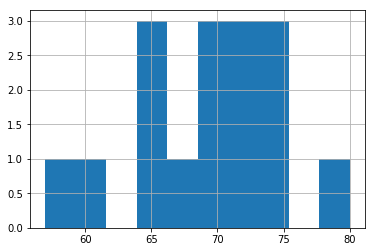

In [7]:
if in_notebook:
    print(corpus.valid.show_itoklist(29629,29629+70))
    print(corpus.valid.show_stoklist(corpus.vocab, 29629,29629+70))
    print(corpus.valid.batch_matrix[:70,1])
    df = corpus.valid.batch_stats()
    df.hist()

In [8]:
train_dl = wiki_data.WikiTextDataset(corpus.train)
valid_dl = wiki_data.WikiTextDataset(corpus.valid)
test_dl = wiki_data.WikiTextDataset(corpus.test)

In [9]:
model = neural.lang_model_LSTM(vocab_dim=len(corpus.vocab),
                               emb_dim=settings.emb_dim,
                               hidden_dim=settings.hidden_dim,
                               n_layers=settings.num_layers,
                               dropout=settings.dropout
                              )

In [10]:
if cuda:
    model = model.cuda()
loss_func = nn.CrossEntropyLoss()

In [11]:
print(model)

lang_model_LSTM(
  (embedding): Embedding(10917, 50)
  (lstm): LSTM(50, 300, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=600, out_features=10917, bias=True)
  (dropout): Dropout(p=0.4)
)


In [12]:
#model = torch.load('model_weights.pt')

In [13]:
missclass = []
missclass_next = []
losses = []

In [14]:
def run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
               losses=[], missclass=[]):
    
    opt = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
    #opt = optim.Adam(model.parameters(), lr=0.001)
    
    
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.8)
    
    best_missclass_te = 1e10
    
    try: # Allow for user interrupt
 
        for epoch in range(1, epochs + 1):
            scheduler.step()
            running_loss = 0.0
            running_corrects = 0
            model.train() # turn on training mode

            num_vals = 0
            num_correct = 0
            miss_next_wd = 0
            next_wd_tot = 0

            #pdb.set_trace()

            for x, y in tqdm(train_dl, desc='Train {}/{}'.format(epoch, epochs)):
                opt.zero_grad()
                
                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                preds = model(x)
                loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())

                loss.backward()
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                opt.step()

                running_loss += loss.item() * x.size(0) / x.size(1)

                _, y_preds = torch.max(preds, dim=2)
                num_correct += torch.sum(y == y_preds).item()
                num_vals += y.size(0)*y.size(1)
                
                miss_next_wd += ml_utils.calc_miss_next_wds(y, y_preds)
                next_wd_tot += y.size(1)

            #pdb.set_trace()

            missclass_tr = 1 - num_correct / num_vals
            miss_next_wd_rate_tr = miss_next_wd / next_wd_tot

            epoch_loss = running_loss / len(train_dl)

            num_vals = 0
            num_correct = 0
            miss_next_wd = 0
            next_wd_tot = 0

            # calculate the validation loss for this epoch
            val_loss = 0.0
            model.eval() # turn on evaluation mode
            
            with torch.no_grad():
                for x, y in tqdm(valid_dl, desc='Valid {}/{}'.format(epoch, epochs)):
                    if cuda:
                        x = x.cuda()
                        y = y.cuda()   
                        
                    preds = model(x)
                    loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())

                    val_loss += loss.item() * x.size(0) / x.size(1)

                    _, y_preds = torch.max(preds, dim=2)
                    num_correct += torch.sum(y == y_preds).item()
                    num_vals += y.size(0)*y.size(1)
                    
                    miss_next_wd += ml_utils.calc_miss_next_wds(y, y_preds)
                    next_wd_tot += y.size(1)

            #pdb.set_trace()

            missclass_te = 1 - num_correct / num_vals
            val_loss /= len(valid_dl)
            
            miss_next_wd_rate_val = miss_next_wd / next_wd_tot
            
            missclass_next.append((miss_next_wd_rate_tr, miss_next_wd_rate_val))
            missclass.append((missclass_tr, missclass_te))
            losses.append((epoch_loss, val_loss))

            print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Ppl: [{:6.2f}, {:6.2f}], Miss: [{:.2%}, {:.2%}], [{:.2%}, {:.2%}]'\
                  .format(epoch, epochs, epoch_loss, val_loss, 
                          math.exp(epoch_loss), math.exp(val_loss), 
                          missclass_tr, missclass_te,
                          miss_next_wd_rate_tr, miss_next_wd_rate_val))
            sys.stdout.flush()

            if missclass_te < best_missclass_te: 
                print('Saving weights file...', end=' ', flush=True)
                torch.save(model, 'model_weights.pt')
                print('Done.', flush=True)
                best_missclass_te = missclass_te
            
    except KeyboardInterrupt:
        print('Stopping with latest weights.')
        
    return model, opt, losses, missclass

In [28]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
                                           losses=losses, missclass=missclass)

Valid 1/50: 100%|██████████| 16/16 [00:25<00:00,  1.60s/it]

Epoch: 1/50, Loss: [5.7184, 5.7274], Ppl: [304.41, 307.17], Miss: [66.88%, 55.06%], [66.42%, 51.62%]
Saving weights file... Done.



Valid 2/50: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]

Epoch: 2/50, Loss: [4.7953, 5.3815], Ppl: [120.94, 217.35], Miss: [56.76%, 50.25%], [59.37%, 48.25%]
Saving weights file... Done.



Valid 3/50: 100%|██████████| 16/16 [00:15<00:00,  1.07it/s]

Epoch: 3/50, Loss: [4.2965, 5.0345], Ppl: [ 73.45, 153.62], Miss: [52.34%, 46.01%], [57.47%, 47.25%]
Saving weights file... Done.



Valid 4/50: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

Epoch: 4/50, Loss: [3.9029, 4.8404], Ppl: [ 49.54, 126.52], Miss: [48.76%, 43.50%], [51.68%, 46.62%]
Saving weights file... Done.



Valid 5/50: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

Epoch: 5/50, Loss: [3.5317, 4.7378], Ppl: [ 34.18, 114.19], Miss: [45.20%, 41.30%], [52.11%, 46.25%]
Saving weights file... Done.



Valid 6/50: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]

Epoch: 6/50, Loss: [3.2169, 4.5932], Ppl: [ 24.95,  98.81], Miss: [42.30%, 39.51%], [48.42%, 46.75%]
Saving weights file... Done.



Valid 7/50: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]

Epoch: 7/50, Loss: [2.9597, 4.5211], Ppl: [ 19.29,  91.94], Miss: [40.24%, 38.39%], [49.26%, 47.12%]
Saving weights file... Done.



Valid 8/50: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]

Epoch: 8/50, Loss: [2.6737, 4.3947], Ppl: [ 14.49,  81.02], Miss: [37.75%, 37.29%], [47.47%, 46.75%]
Saving weights file... Done.



Valid 9/50: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

Epoch: 9/50, Loss: [2.4045, 4.2903], Ppl: [ 11.07,  72.99], Miss: [35.51%, 35.92%], [46.74%, 46.88%]
Saving weights file... Done.



Valid 10/50: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]

Epoch: 10/50, Loss: [2.1482, 4.2315], Ppl: [  8.57,  68.82], Miss: [32.94%, 35.09%], [44.74%, 46.62%]
Saving weights file... Done.



Valid 11/50: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

Epoch: 11/50, Loss: [1.9431, 4.1842], Ppl: [  6.98,  65.64], Miss: [30.95%, 34.82%], [42.84%, 46.75%]
Saving weights file... Done.



Valid 12/50: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

Epoch: 12/50, Loss: [1.7401, 4.0752], Ppl: [  5.70,  58.86], Miss: [28.75%, 33.57%], [41.47%, 47.38%]
Saving weights file... Done.



Valid 13/50: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

Epoch: 13/50, Loss: [1.5695, 4.0692], Ppl: [  4.80,  58.51], Miss: [26.78%, 33.11%], [37.58%, 47.38%]
Saving weights file... Done.



Valid 14/50: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

Epoch: 14/50, Loss: [1.4070, 4.0059], Ppl: [  4.08,  54.92], Miss: [24.77%, 32.33%], [38.00%, 47.25%]
Saving weights file... Done.



Valid 15/50: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]

Epoch: 15/50, Loss: [1.2607, 3.9912], Ppl: [  3.53,  54.12], Miss: [22.54%, 32.29%], [36.74%, 46.62%]
Saving weights file... Done.



Valid 16/50: 100%|██████████| 16/16 [00:17<00:00,  1.09s/it]

Epoch: 16/50, Loss: [1.1083, 3.9286], Ppl: [  3.03,  50.83], Miss: [20.16%, 31.67%], [35.89%, 46.88%]
Saving weights file... Done.



Valid 17/50: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]

Epoch: 17/50, Loss: [0.9655, 3.9142], Ppl: [  2.63,  50.11], Miss: [17.81%, 31.49%], [33.37%, 47.00%]
Saving weights file... Done.



Valid 18/50: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s]

Epoch: 18/50, Loss: [0.8673, 3.8978], Ppl: [  2.38,  49.29], Miss: [16.03%, 30.99%], [32.74%, 47.38%]
Saving weights file... Done.



Valid 19/50: 100%|██████████| 16/16 [00:17<00:00,  1.07s/it]

Epoch: 19/50, Loss: [0.7685, 3.8731], Ppl: [  2.16,  48.09], Miss: [14.41%, 30.91%], [32.74%, 46.75%]
Saving weights file... Done.



Valid 20/50: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]

Epoch: 20/50, Loss: [0.6896, 3.8765], Ppl: [  1.99,  48.26], Miss: [12.94%, 30.78%], [31.79%, 47.62%]
Saving weights file... Done.



Valid 21/50: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]

Epoch: 21/50, Loss: [0.6020, 3.7967], Ppl: [  1.83,  44.55], Miss: [11.22%, 30.13%], [29.37%, 47.12%]
Saving weights file... Done.



Valid 22/50: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]

Epoch: 22/50, Loss: [0.5287, 3.7250], Ppl: [  1.70,  41.47], Miss: [9.73%, 29.88%], [27.89%, 46.75%]
Saving weights file... Done.



Valid 23/50: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]

Epoch: 23/50, Loss: [0.4697, 3.7110], Ppl: [  1.60,  40.90], Miss: [8.62%, 29.71%], [26.00%, 47.12%]
Saving weights file... Done.



Valid 24/50: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]

Epoch: 24/50, Loss: [0.4169, 3.7129], Ppl: [  1.52,  40.97], Miss: [7.55%, 29.56%], [26.00%, 47.62%]
Saving weights file... Done.



Valid 25/50: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]

Epoch: 25/50, Loss: [0.3803, 3.6681], Ppl: [  1.46,  39.18], Miss: [6.68%, 29.24%], [24.11%, 47.50%]
Saving weights file... Done.



Valid 26/50: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]

Epoch: 26/50, Loss: [0.3411, 3.6538], Ppl: [  1.41,  38.62], Miss: [5.93%, 28.92%], [24.42%, 47.38%]
Saving weights file... Done.



Valid 27/50: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]

Epoch: 27/50, Loss: [0.3107, 3.6412], Ppl: [  1.36,  38.14], Miss: [5.39%, 28.77%], [21.47%, 47.25%]
Saving weights file... Done.



Valid 28/50: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

Epoch: 28/50, Loss: [0.2877, 3.6507], Ppl: [  1.33,  38.50], Miss: [4.86%, 28.86%], [21.37%, 48.00%]



Train 29/50:   5%|▌         | 1/19 [00:03<00:55,  3.10s/it]

Stopping with latest weights.


In [29]:
x, y = next(iter(valid_dl))
if cuda:
    x = x.cuda()
    y = y.cuda()
loss_func = nn.CrossEntropyLoss()
preds = model(x)
_, y_preds = torch.max(preds, dim=2)
ml_utils.calc_miss_next_wds(y, y_preds)
loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())
loss

tensor(2.9636, grad_fn=<NllLossBackward>)

In [30]:
print(y.shape)
print(y[:,2])

torch.Size([70, 50])
tensor([6643,   14,  474, 6663, 1136,   18, 3774,   17,    3, 3672,    3,  413,
           3,  502,   11,    3, 6664,   20,    3, 5995,    3,  341,   46, 2026,
        1702, 2551,   14,    3, 6664,    3,    8,   16, 6665,    3, 2435,    3,
        6661,  117, 2176,   23, 6666,   72,   18,    3, 6667, 1702,    3, 6668,
           2,   14,    3, 6669,    3, 1585,   17,   18,    3, 3672,    3,  586,
          46, 6666, 1702, 1843,   14,   39,    3, 6664,    3,  545])


In [31]:
print(y_preds[:,2])

tensor([2058,   14,  474, 1278, 1136,   18, 1401,   17,    3,  521,    3,  413,
           3, 3313,   11,    3, 5950,   20,    3, 5471,    3,  341,   46, 3843,
        1702,  701,   14,    3, 1796,    3,  468,   16, 3918,    3, 2435,    3,
        3924,  117,  988,   23, 1548,   72,   18,    3,   65, 1702,    3,  430,
           2,   14,    3, 1796,    3, 1585,   17,   18,    3, 3672,    3,  457,
          46, 3500, 1702, 1715,   14,   39,    3, 1796,    3, 1758])


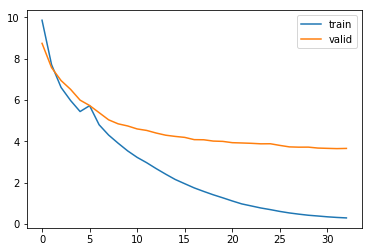

In [32]:
if in_notebook:
    plt.plot(losses)
    plt.legend(['train', 'valid'])

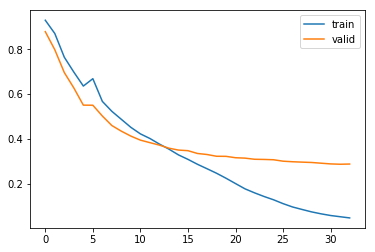

In [33]:
if in_notebook:
    plt.plot(missclass)
    plt.legend(['train', 'valid'])

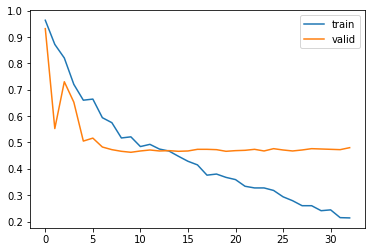

In [34]:
if in_notebook:
    plt.plot(missclass_next)
    plt.legend(['train', 'valid'])

In [35]:
print('losses =', losses)
print('missclass =', missclass)
print('missclass_next =', missclass_next)

losses = [(9.85296713879234, 8.734478332400322), (7.703589562365883, 7.561258778572083), (6.602057563882125, 6.93454685330391), (5.968885494533337, 6.509060522317887), (5.435221888140629, 5.9868359595537175), (5.71837361862785, 5.727385249733925), (4.7952721593254495, 5.381504732370377), (4.296545973075064, 5.034509737491609), (3.9028769756618296, 4.840398742258548), (3.531744946680571, 4.73782262712717), (3.2169426576714772, 4.593216481208802), (2.9596557775296666, 4.5211131429672236), (2.6736561492869733, 4.394748745560646), (2.404519958496094, 4.290293128192425), (2.1481870296126915, 4.231501913964748), (1.9431496756955193, 4.184197981953621), (1.7401057810532423, 4.075236743986606), (1.569538859819111, 4.069156402945518), (1.4069676295707103, 4.005944408476353), (1.2606753135354896, 3.991165669858456), (1.1083284378679172, 3.9285782030224805), (0.965533598159489, 3.914222409427165), (0.8673239154564707, 3.897821213304996), (0.7685122565219276, 3.873063178360462), (0.689556532564916